In [3]:
import math as math
import pandas as pd
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [9]:
# Set paths to the data source location here...
# PLEASE CHANGE THIS TO WHERE YOUR CSV FILES ARE LOCATED
path = ""

In [11]:
data = pd.read_csv(f'{path}locations1.csv')
data.head()

,x,y
0,0.321665,-0.277641
1,0.838688,-0.565661
2,0.778286,0.130336
3,0.755618,0.065864
4,1.298365,0.255950


## Clustering Methodology

/Users/ab/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


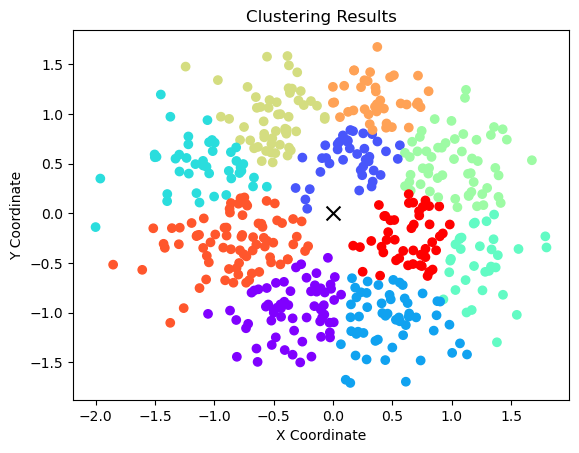

In [12]:
X = data[['x', 'y']]

num_clusters = 10 # num clusters = num trucks

# create and fit a K-Means model 
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
data['cluster_label'] = kmeans.labels_
plt.scatter(data['x'], data['y'], c=data['cluster_label'], cmap='rainbow')
plt.title('Clustering Results')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.scatter(0, 0, c='black', marker='x', s=100)  # Adjust the size (s) as needed
plt.show()

In [13]:
data.head()

,x,y,cluster_label
0,0.321665,-0.277641,9
1,0.838688,-0.565661,9
2,0.778286,0.130336,9
3,0.755618,0.065864,9
4,1.298365,0.255950,5


In [18]:
# perform TSP for each truck

for cluster in range(num_clusters):
    cluster_data = data[data['cluster_label'] == cluster]
    cluster_coordinates = cluster_data[['x', 'y']].values
    num_points = len(cluster_coordinates)
    distMat = np.zeros((num_points, num_points)) # empty distance matrix
    
    # calculate the distance between each pair of points in the cluster
    for i in range(num_points):
        for j in range(i, num_points):
            distance = np.linalg.norm(cluster_coordinates[i] - cluster_coordinates[j])
            distMat[i, j] = distance
            distMat[j, i] = distance 
            
    for i in range(num_points):
        for j in range(num_points):
             if distMat[i, j] == 0:
                distMat[i, j] = 1000

    print(f'TSP for truck {cluster+1}')

    # integer program

    N = len(distMat)
    mod = gp.Model()
    x = mod.addMVar((N,N),vtype='B') # NxN 
    u = mod.addMVar(N)
    mod.setObjective(gp.quicksum(x[i,j]*distMat[i,j] for i in range(N) for j in range(N)))

    # constraints

    # enter each city once
    enter = mod.addConstrs((gp.quicksum(x[i,j] for i in range(N))==1) for j in range(N))
    # leave each city once
    leave = mod.addConstrs((gp.quicksum(x[i,j] for j in range(N))==1) for i in range(N))
    # u constraints:
    ucons = mod.addConstrs((u[i] - u[j] + N*x[i,j] <= (N-1)) for i in range(1,N) for j in range(1,N) if i != j)

    mod.Params.OutputFlag = 0
    mod.optimize()
    print(mod.objVal)
    print('')

TSP for truck 1
6.241319996371333

TSP for truck 2
3.939687433805952

TSP for truck 3
6.087296567849306

TSP for truck 4
6.222347342020558

TSP for truck 5
4.605616454508971

TSP for truck 6
6.0501631626840515

TSP for truck 7
5.694038931431706

TSP for truck 8
3.8959632890197353

TSP for truck 9
7.821730135156804

TSP for truck 10
4.300959678239126



## Simulated Annealing

In [17]:
data.head()

,x,y,cluster_label
0,0.321665,-0.277641,9
1,0.838688,-0.565661,9
2,0.778286,0.130336,9
3,0.755618,0.065864,9
4,1.298365,0.255950,5


In [ ]:
# Function to cause a reverse change to a path
''' For a reverse change you randomly pick 2 nodes, 1 is labeled the starting node, 
and 1 is labeled the ending node; let’s say these nodes are i and j. We find the segment 
of the path that starts at node i and goes to node j, disconnect it from the entire path, 
reverse it and put it back into the path. For example, if we had a 6-node problem and we 
have a path that goes 0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 0, and randomly picked the starting 
node to be node 5 and the ending node to be 2, then the segment of the path that connects 
5 to 2 is 5 -> 0 -> 1 -> 2. To reverse this path, we find the node that used to go into 5, 
and make it go into 2, and find the node that used to come after 2 and make it come after 5, 
so now the new path after reversing would 4 -> 2 -> 1 -> 0 -> 5 -> 3 -> 4.  '''
def reverse(path):
    nx = len(path)
    startstop = np.random.choice(nx,2,replace=False)
    if startstop[0] > startstop[1]:
        remove_path = np.append(path[startstop[0]:],path[:(startstop[1]+1)])
        closed_path = path[(startstop[1]+1):startstop[0]]
    else:
        remove_path = path[startstop[0]:(startstop[1]+1)]
        closed_path = np.append(path[0:startstop[0]],path[(startstop[1]+1):])
    nc = len(closed_path)
    if nc > 0:
        # Reverse the path 
        remove_path.reverse()
        if startstop[0] > startstop[1]:
            # TODO: Does it matter whether the first and last index in the path list are equal?
            newpath = np.append(closed_path[0:startstop[0]],remove_path,closed_path[(startstop[1]+1):])
        else: 
            newpath = np.append(closed_path[0:startstop[0]],remove_path,closed_path[(startstop[1]+1):])
    else:
        newpath = path
    return newpath

In [ ]:
# Function to cause a transport change to a path
def transport(path):
    nx = len(path)
    startstop = np.random.choice(nx,2,replace=False)
    if startstop[0] > startstop[1]:
        remove_path = np.append(path[startstop[0]:],path[:(startstop[1]+1)])
        closed_path = path[(startstop[1]+1):startstop[0]]
    else:
        remove_path = path[startstop[0]:(startstop[1]+1)]
        closed_path = np.append(path[0:startstop[0]],path[(startstop[1]+1):])
    nc = len(closed_path)
    if nc > 0:
        paste = np.random.choice(nc,1)[0]
        newpath = np.append(closed_path[0:(paste+1)],remove_path)#,closed_path[(paste+1):])
        newpath = np.append(newpath,closed_path[(paste+1):])
    else:
        newpath = path
    return newpath
    

In [ ]:
# Function to calculate the total distance taken by a truck in a given path
def measure_path(path,dist):
    nx = len(path)
    total_dist = 0
    for i in range(nx-1):
        total_dist += dist[path[i],path[i+1]]
    total_dist += dist[path[nx-1],path[0]]
    return total_dist

In [19]:
# Create distance matrix for all pairs of points
nx = data.shape[0]
dist = np.zeros((nx,nx))
for i in range(nx):
    for j in range(nx):
        if i == j:
            dist[i,j] = 10000
        else:
            dist[i,j] = np.sqrt((data['x'][i]-data['x'][j])**2 + (data['y'][i]-data['y'][j])**2)

# "Initialize a loop completely at random" - randomly chosen path
path = np.random.choice(nx,nx,False)

# Set limit for number of iterations before termination
N = 100000

# initialize the epsilon value <= 1
eps = 0.5

for i in range(N):
    # "Toss a fair coin" to pick randomly between reverse & transport Change
    new_path = transport(path) if  np.random.choice([0,1]) == 1 else reverse(path)
    new_distance = measure_path(new_path)
    curr_distance = measure_path(path)

    if (new_distance < curr_distance):
        path = new_path
    else:
        d = new_distance - curr_distance
        prob = eps/math.exp(d)
        path = new_path if np.random.choice([0,1], p=[1-prob,prob]) == 1 else path

    eps *= 0.99



